In [1]:
import torch

from roarena.einmon import EinMonJob
from scipy.fft import fft2, ifft2

job = EinMonJob('store', 'datasets', readonly=True)

In [2]:
device = 'cuda'
seed = 0

model_path = 'store/models/CIFAR10-G_Baseline.pt'
model = torch.load(model_path)['model']
model.eval().to(device)

accs_high, accs_low, confs = {}, {}, {}
for alpha in [i*25 for i in range(5)]:
    dataset = job.prepare_dataset('CIFAR10-Gray', alpha, seed)
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=16,
    )
    labels_high, labels_low, preds, max_probs = [], [], [], []
    for _images, _labels_high, _labels_low in loader:
        with torch.no_grad():
            _logits = model(_images.to(device))
            _probs = torch.softmax(_logits, dim=1)
            _probs, _preds = _probs.max(dim=1)
        labels_high.append(_labels_high)
        labels_low.append(_labels_low)
        preds.append(_preds.cpu())
        max_probs.append(_probs.cpu())
    labels_high = torch.cat(labels_high).numpy()
    labels_low = torch.cat(labels_low).numpy()
    preds = torch.cat(preds).numpy()
    max_probs = torch.cat(max_probs).numpy()
    
    accs_high[alpha] = (labels_high==preds).mean()*100
    accs_low[alpha] = (labels_low==preds).mean()*100
    confs[alpha] = max_probs.mean()*100

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})
import numpy as np

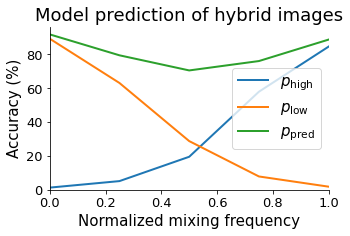

In [9]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(np.array(list(accs_high.keys()))/100, accs_high.values())
ax.plot(np.array(list(accs_high.keys()))/100, accs_low.values())
ax.plot(np.array(list(confs.keys()))/100, confs.values())
ax.set_xlim([0, 1])
ax.set_ylim([0, None])
ax.set_xlabel('Normalized mixing frequency')
ax.set_ylabel('Accuracy (%)')
ax.legend(['$p_\mathrm{high}$', '$p_\mathrm{low}$', '$p_\mathrm{pred}$'])
ax.set_title('Model prediction of hybrid images')
plt.show()

fig.savefig(f'hybrid.predictions.svg')